In [6]:
import pandas as pd
import numpy as np

In [7]:
movies = pd.read_csv('movies.csv')
users = pd.read_csv('users.csv')
ratings = pd.read_csv('ratings.csv')

In [9]:
def create_ratings_matrix(ratings):
    matrix = np.zeros((ratings["user id"].max(),ratings["item id"].max()))
    for index, row in ratings.iterrows():
        matrix[row["user id"]-1, row["item id"]-1] = row["rating"]
    return matrix
ratings_matrix = create_ratings_matrix(ratings)

In [10]:
ratings_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [13]:
display(users)

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


## Scenarios

User-coldstart <br>
Movie-coldstart<br>
Given user-recommend movies<br>
Given movie-recommend users<br>
Predict ratings<br>

## Model

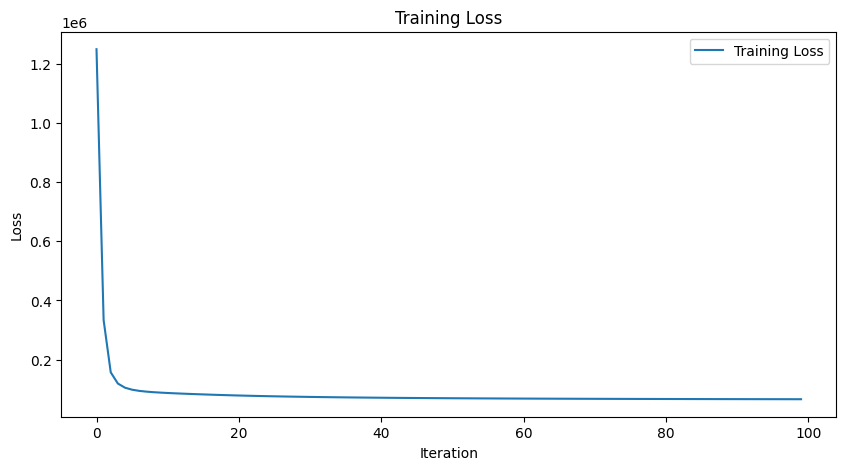

Iteration: 100; Loss: 65553.55434923113
Predicted rating of user 0 for item 2: 3.770345194686876


In [326]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output

class BasicMatrixFactorization:
    def __init__(self, ratings, num_features=10, learning_rate=0.01, reg_param=0.02, max_iter=5000):
        """
        :param ratings: A matrix of user-item ratings
        :param num_features: Number of latent features
        :param learning_rate: Learning rate for SGD
        :param reg_param: Regularization parameter
        :param max_iter: Maximum number of iterations for SGD
        """
        self.ratings = ratings
        self.num_users, self.num_items = ratings.shape
        self.num_features = num_features
        self.learning_rate = learning_rate
        self.reg_param = reg_param
        self.max_iter = max_iter

        # Initialize user and item latent feature matrix
        self.user_features = np.random.normal(scale=1./num_features, size=(self.num_users, num_features))
        self.item_features = np.random.normal(scale=1./num_features, size=(self.num_items, num_features))

    def train(self):
        loss_history = []  # Keep track of the loss over iterations

        for iteration in range(self.max_iter):
            current_learning_rate = self.learning_rate * (0.99 ** iteration)

            for i in range(self.num_users):
                for j in range(self.num_items):
                    if self.ratings[i, j] > 0:
                        prediction = self.predict(i, j)
                        error = self.ratings[i, j] - prediction

                        self.user_features[i, :] += current_learning_rate * \
                                                    (error * self.item_features[j, :] - self.reg_param * self.user_features[i, :])
                        self.item_features[j, :] += current_learning_rate * \
                                                    (error * self.user_features[i, :] - self.reg_param * self.item_features[j, :])

            loss = self.compute_loss()
            loss_history.append(loss)

            # Real-time plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(loss_history, label='Training Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.legend()
            plt.show()

            print(f"Iteration: {iteration + 1}; Loss: {loss}")


    def predict(self, user, item):
        """
        Predict a rating by a user for an item
        """
        return np.dot(self.user_features[user, :], self.item_features[item, :])

    def compute_loss(self):
        """
        Compute total loss (error + regularization penalty)
        """
        prediction = self.user_features.dot(self.item_features.T)
        error = np.sum((self.ratings[np.where(self.ratings > 0)] - prediction[np.where(self.ratings > 0)]) ** 2)
        penalty = self.reg_param * (np.sum(np.square(self.user_features)) + np.sum(np.square(self.item_features)))
        return error + penalty
        
    
    def recommend_users(self, movie_ids, num_recommendations=10):
        """
        Recommend users for a given list of movie IDs.

        :param movie_ids: A list of movie IDs for which to recommend users.
        :param num_recommendations: Number of top user recommendations to return for each movie.
        :return: A dictionary where keys are movie IDs and values are lists of recommended user IDs.
        """
        recommendations = []
        for movie_id in movie_ids:
            # Predict ratings for all users for the given item
            movie_ratings = np.array([self.predict(user_id, movie_id) for user_id in range(self.num_users)])
            
            # Get indices of users with the highest predicted ratings
            # Use argsort and then reverse it to get descending order, and slice the top N
            recommended_users = np.argsort(movie_ratings)[::-1][:num_recommendations]
            
            recommendations.append(recommended_users)
        
        return recommendations
    
    def recommend_movies(self, user_ids, num_recommendations=10):
        """
        Recommend users for a given list of user IDs.
        """
        recommendations = [];
        for user_id in user_ids:
            # Predict ratings for all users for the given item
            user_ratings = np.array([self.predict(user_id, movie_id) for movie_id in range(self.num_items)])
            
            # Get indices of users with the highest predicted ratings
            # Use argsort and then reverse it to get descending order, and slice the top N
            recommended_movies = np.argsort(user_ratings)[::-1][:num_recommendations]
            
            recommendations.append(recommended_movies)
        
        return recommendations
    
# Example usage
if __name__ == "__main__":
    np.random.seed(0)  # For reproducibility

    mf_model = BasicMatrixFactorization(ratings_matrix, num_features=5, learning_rate=0.005, reg_param=0.02, max_iter=100)
    mf_model.train()

    # Predict the rating of user 0 for item 2
    print(f"Predicted rating of user 0 for item 2: {mf_model.predict(0, 2)}")


In [318]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

class ExtendedMatrixFactorizationForUsers(BasicMatrixFactorization):
    def __init__(self, ratings, user_metadata, num_features=10, learning_rate=0.01, reg_param=0.002, max_iter=200):
        super().__init__(ratings, num_features, learning_rate, reg_param, max_iter)
        metadata = user_metadata
        
        metadata = metadata.drop('user id', axis=1)
        metadata = metadata.drop('age', axis=1)
        metadata = metadata.drop('zip code', axis=1)
        
        self.user_metadata = metadata
        
        self.encoded_metadata, self.encoder = self._preprocess_metadata(self.user_metadata)
        self.nearest_neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
        
        self.nearest_neighbors.fit(self.encoded_metadata)

    def _preprocess_metadata(self, metadata):        
        # Initialize the OneHotEncoder
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        
        # Select categorical features for encoding
        categorical_features = ['gender', 'occupation']
        categorical_data = metadata[categorical_features]
        
        # Fit and transform the categorical data
        encoded_data = encoder.fit_transform(categorical_data)
        
        return encoded_data, encoder
    
    def recommend_movies_for_new_users(self, users_metadata, num_recommendations=10):
        recommendations = []

        # Ensure users_metadata is prepared correctly: drop 'user id' and 'age', if present
        if 'user id' in users_metadata.columns:
            users_metadata = users_metadata.drop('user id', axis=1)
        if 'age' in users_metadata.columns:
            users_metadata = users_metadata.drop('age', axis=1)
        if 'zip code' in users_metadata.columns:
            users_metadata = users_metadata.drop('zip code', axis=1)

        # Now, the transformed_metadata will have the same structure as during fitting
        transformed_metadata = self.encoder.transform(users_metadata)

        # Find k nearest neighbors for each user
        _, indices = self.nearest_neighbors.kneighbors(transformed_metadata)

        for i, user_index in enumerate(indices):
            average_latent_features = np.mean(self.user_features[user_index.flatten()], axis=0)
            predicted_ratings = np.dot(average_latent_features, self.item_features.T)
            recommended_movie_indices = np.argsort(predicted_ratings)[::-1][:num_recommendations]

            recommendations.append(recommended_movie_indices)

        return recommendations



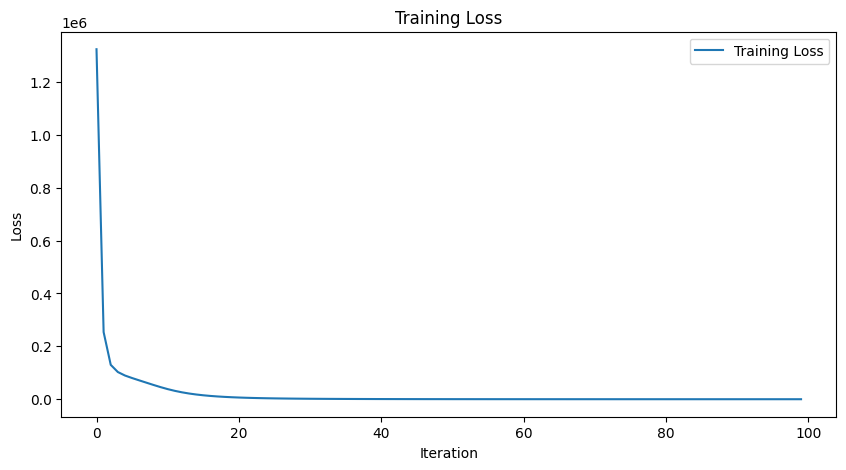

Iteration: 100; Loss: 104.48392409743386


In [234]:
user_model = ExtendedMatrixFactorizationForUsers(ratings_matrix, users, num_features=200, learning_rate=0.02, reg_param=0.002, max_iter=100)
user_model.train()

In [267]:
movies

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

class ExtendedMatrixFactorizationForMovies(BasicMatrixFactorization):
    def __init__(self, ratings, movie_metadata, num_features=10, learning_rate=0.01, reg_param=0.02, max_iter=5000):
        super().__init__(ratings, num_features, learning_rate, reg_param, max_iter)
        self.movie_metadata = movie_metadata
        # Only use genre columns for similarity
        self.genre_data = movie_metadata.iloc[:, 5:].to_numpy()
        self.nearest_neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
        self.nearest_neighbors.fit(self.genre_data)

    def recommend_users_for_new_movies(self, movie_indices, num_recommendations=10):
        """
        Recommend users for multiple new movies by finding k nearest existing movies based on genres.

        :param movies_genres: A numpy array where each row contains the genre information of a new movie.
        :param num_recommendations: Number of top user recommendations to return for each movie.
        :return: A dictionary where keys are indices of the new movies and values are lists of recommended user IDs.
        """
        movies_genres = self.genre_data[movie_indices, :];
        recommendations = []

        # Iterate over each new movie's genres
        for movie_idx, movie_genres in enumerate(movies_genres):
            # Find k nearest existing movies based on genres
            _, indices = self.nearest_neighbors.kneighbors([movie_genres])

            # Average the latent features of nearest movies
            average_movie_features = np.mean(self.item_features[indices.flatten()], axis=0)

            # Predict ratings for all users for this new movie
            predicted_ratings = np.dot(self.user_features, average_movie_features.T)

            # Recommend the top-N users
            recommended_user_indices = np.argsort(predicted_ratings)[::-1][:num_recommendations]

            # Store recommendations for this movie
            recommendations.append(recommended_user_indices)

        return recommendations


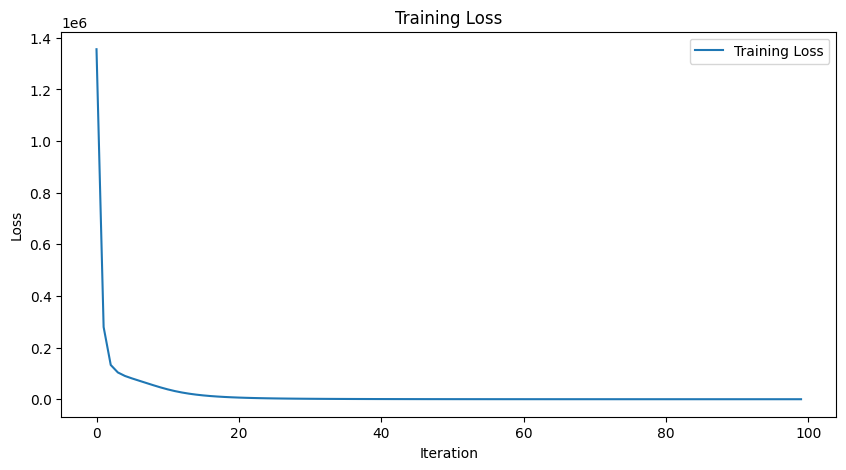

Iteration: 100; Loss: 103.19274025936656


In [259]:
movie_model = ExtendedMatrixFactorizationForMovies(ratings_matrix, movies, num_features=200, learning_rate=0.02, reg_param=0.002, max_iter=100)
movie_model.train()

## Evaluation

In [333]:
max_num_test = 10


def rmse(values_1, values_2):
    return np.sqrt(np.square(values_1 - values_2).mean())


def precision(true_values, predicted_values):
#     print("true_values-------------", true_values)
#     print("predicted_values--------------", predicted_values)
    true_values = set(true_values)
    predicted_values = set(predicted_values)
    intersection = true_values.intersection(predicted_values)
    return len(intersection) / len(predicted_values)


def evaluate_scenario_1(model, ratings_matrix, num_recommendations=10):

  # New user - cold start

    user_indexes = []
    for (ii, ratings) in enumerate(ratings_matrix):
        if len(np.where(ratings > 3)[0]) > 2 * num_recommendations:
            user_indexes.append(ii)
    user_indexes = np.array(user_indexes[:max_num_test])

    modified_ratings = ratings_matrix.copy()
    modified_ratings[user_indexes] = 0
    
    user_data = users.iloc[user_indexes]

    recommended_movies = model.recommend_movies_for_new_users(user_data, num_recommendations)
    true_values = [np.where(ratings_matrix[user_index] > 3)[0] + 1 for user_index in user_indexes]
        
    precisions = np.array([precision(true_values[ii], recommended_movies[ii]) for ii in range(len(user_indexes))])
    return precisions.mean()


def evaluate_scenario_2(model, ratings_matrix, num_recommendations=10):

  # New movie - cold start

    movie_indexes = []
    for (ii, ratings) in enumerate(ratings_matrix.T):
        if len(np.where(ratings > 3)[0]) > 2 * num_recommendations:
            movie_indexes.append(ii)
    movie_indexes = np.array(movie_indexes[:max_num_test])

    modified_ratings = ratings_matrix.copy()
    modified_ratings[:, movie_indexes] = 0

    recommended_users = model.recommend_users_for_new_movies(movie_indexes, num_recommendations)
    true_values = [np.where(ratings_matrix.T[movie_index] > 3)[0] + 1
                   for movie_index in movie_indexes]
    precisions = np.array([precision(true_values[ii],
                          recommended_users[ii]) for ii in
                          range(len(movie_indexes))])
    return precisions.mean()


def evaluate_scenario_3(model, ratings_matrix, num_recommendations=10):

  # Given user

    user_indexes = []
    for (ii, ratings) in enumerate(ratings_matrix):
        if len(np.where(ratings > 3)[0]) > 4 * num_recommendations:
            user_indexes.append(ii)
    user_indexes = np.array(user_indexes[:max_num_test])

    modified_ratings = ratings_matrix.copy()
    true_values = []
    for user_index in user_indexes:
        removed_indexes = np.where(ratings_matrix[user_index] > 3)[0][::
                2]
        true_values.append(removed_indexes + 1)
        modified_ratings[user_index, removed_indexes] = 0

    recommended_movies = model.recommend_movies(
            user_indexes + 1, num_recommendations)
    precisions = np.array([precision(true_values[ii],
                          recommended_movies[ii]) for ii in
                          range(len(user_indexes))])
    return precisions.mean()


def evaluate_scenario_4(model, ratings_matrix, num_recommendations=10):

  # Given movie

    movie_indexes = []
    for (ii, ratings) in enumerate(ratings_matrix.T):
        if len(np.where(ratings > 3)[0]) > 4 * num_recommendations:
            movie_indexes.append(ii)
    movie_indexes = np.array(movie_indexes[:max_num_test])

    modified_ratings = ratings_matrix.copy()
    true_values = []
    for movie_index in movie_indexes:
        removed_indexes = np.where(ratings_matrix.T[movie_index]
                                   > 3)[0][::2]
        true_values.append(removed_indexes + 1)
        modified_ratings[removed_indexes, movie_index] = 0

    recommended_users = model.recommend_users(
            movie_indexes, num_recommendations)
    precisions = np.array([precision(true_values[ii],
                          recommended_users[ii]) for ii in
                          range(len(movie_indexes))])
    return precisions.mean()


def evaluate_scenario_5(model, ratings_matrix, num_recommendations=10):

  # Predict rating

    user_ids = np.array(range(0, ratings_matrix.shape[0], 20)) + 1
    movie_ids = np.array(range(0, ratings_matrix.shape[1], 20)) + 1

    rating_ids = []
    for uid in user_ids:
        for mid in movie_ids:
            if ratings_matrix[uid - 1, mid - 1] != 0:
                rating_ids.append((uid, mid))

    true_values = np.array([ratings_matrix[uid - 1, mid - 1] for (uid,
                           mid) in rating_ids])
    predicted_values = [];
    for uid, mid in rating_ids:
        predicted_values.append(model.predict(uid, mid))
    return rmse(true_values, predicted_values)


## Evaluating Matrix Factorization model

In [270]:
print("evaluate_scenario_1 (Cold start user) Precision: ", evaluate_scenario_1(user_model, ratings_matrix, num_recommendations=10))

evaluate_scenario_1 (Cold start user) Precision:  0.24000000000000005


In [281]:
print("evaluate_scenario_2 (Cold start movie) Precision: ", evaluate_scenario_2(movie_model, ratings_matrix, num_recommendations=10))

evaluate_scenario_2 (Cold start movie) Precision:  0.06000000000000001


In [338]:
print("evaluate_scenario_3 (Given user) Precision: ", evaluate_scenario_3(mf_model, ratings_matrix, num_recommendations=50))

evaluate_scenario_3 (Given user) Precision:  0.136


In [337]:
print("evaluate_scenario_4 (Given movie) Precision: ", evaluate_scenario_4(mf_model, ratings_matrix, 50))

evaluate_scenario_4 (Given movie) Precision:  0.11400000000000002


In [336]:
print("evaluate_scenario_5 (Predicting missing values) RMSE: ", evaluate_scenario_5(mf_model, ratings_matrix, 20))

evaluate_scenario_5 (Predicting missing values) RMSE:  1.3936174047348706
